In [1]:
import yt
import numpy as np
import glob
import matplotlib.pyplot as plt

/home/bendp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
FILENAMES = ["./build/Exec/RiemannProblem/output/test1/plt?????",
             "./build/Exec/RiemannProblem/output/test2/plt?????",
             "./build/Exec/RiemannProblem/output/test3/plt?????",
             "./build/Exec/RiemannProblem/output/test4/plt?????",
             "./build/Exec/RiemannProblem/output/test5/plt?????"]
# FILENAMES = ["./build/Exec/RiemannProblem/output/test2/plt?????"]
adiabatic = 1.4

/tmp/ipykernel_718/1617356706.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


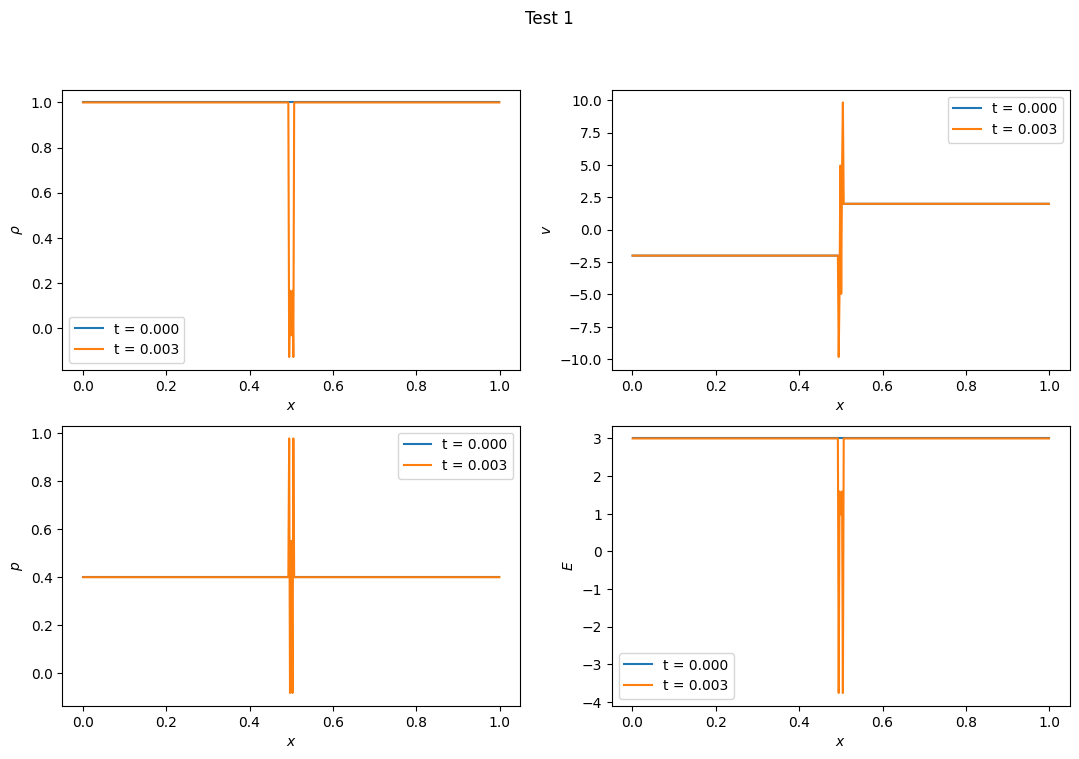

In [15]:
yt.set_log_level("error")
for i, FILENAME in enumerate(FILENAMES):
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    for ds in ts:
        ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
        time_label = f"t = {ds.current_time.value:.3f}"
        density = np.array(ray["density"])
        mom_x = np.array(ray["mom_x"])
        energy = np.array(ray["energy"])
        vel_x = mom_x / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        x = np.array(ray["x"])
        # print(density)
        ax[0,0].plot(x,density,label=time_label)
        ax[0,1].plot(x,vel_x,label=time_label)
        ax[1,0].plot(x,pressure,label=time_label)
        ax[1,1].plot(x,energy,label=time_label)

    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    ax[0,0].set_xlabel("$x$")
    ax[0,1].set_xlabel("$x$")
    ax[1,0].set_xlabel("$x$")
    ax[1,1].set_xlabel("$x$")

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

In [9]:
help(ds)

Help on BoxlibDataset in module yt.frontends.boxlib.data_structures object:

class BoxlibDataset(yt.data_objects.static_output.Dataset)
 |  BoxlibDataset(output_dir, cparam_filename=None, fparam_filename=None, dataset_type='boxlib_native', storage_filename=None, units_override=None, unit_system='cgs', default_species_fields=None)
 |  
 |  This class is a stripped down class that simply reads and parses
 |  *filename*, without looking at the Boxlib index.
 |  
 |  Method resolution order:
 |      BoxlibDataset
 |      yt.data_objects.static_output.Dataset
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, output_dir, cparam_filename=None, fparam_filename=None, dataset_type='boxlib_native', storage_filename=None, units_override=None, unit_system='cgs', default_species_fields=None)
 |      The paramfile is usually called "inputs"
 |      and there may be a fortran inputs file usually called "probin"
 |      plotname here will be a directory name